## Building a chatbot with multiple tools using langgraph"

In [156]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [157]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [158]:
arxiv.invoke('Attention is all you need')

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [159]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [160]:
wiki.invoke('What is machine learning?')

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [161]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

In [162]:
from langchain_tavily import TavilySearch

travily = TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [163]:
travily.invoke('provide me the mostv recent ai news for 14 August 2025')

{'query': 'provide me the mostv recent ai news for 14 August 2025',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://dwealth.news/2025/08/ai-intelligence-weekly-top-10-8-14-25/',
   'title': 'AI INTELLIGENCE | Weekly Top 10 (8/14/25) - Dwealth.news',
   'content': 'Viral AI stories this week: USAi launch, Illinois AI therapy ban, GPT-5 price shake-up, and a viral Reddit engagement to an AI chatbot.',
   'score': 0.83452857,
   'raw_content': None},
  {'url': 'https://www.artificialintelligence-news.com/',
   'title': 'AI News | Latest AI News, Analysis & Events',
   'content': 'DeepSeek reverts to Nvidia for R2 model after Huawei AI chip fails · Artificial Intelligence. August 14, 2025 ; Anthropic details its AI safety strategy.',
   'score': 0.8184036,
   'raw_content': None},
  {'url': 'https://www.theguardian.com/technology/artificialintelligenceai',
   'title': 'Artificial intelligence (AI) | The Guardian',
   'content': '14 August 2025 · 

In [164]:
### Combine all tools in a list

tools=[arxiv,wiki,travily]

### Initialize llm model

from langchain_groq import ChatGroq

llm=ChatGroq(model='qwen/qwen3-32b')

llm_with_tools=llm.bind_tools(tools)

In [165]:
from langchain_core.messages import HumanMessage,AIMessage

llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to figure out which tool to use here. The available tools are arxiv, wikipedia, and tavily_search. Arxiv is for academic papers, which might not be what they\'re looking for. Wikipedia is good for general knowledge but might not have the latest news. Tavily_search seems appropriate here because it\'s optimized for current events and can provide up-to-date results.\n\nLooking at the parameters for tavily_search, the user wants recent news, so I should set the time_range to "week" to get the latest developments. The topic should be "general" unless specified otherwise. The query itself would be "recent AI news". I don\'t need to exclude or include specific domains unless the user mentioned them, which they didn\'t. Also, no need for images or favicons unless specified. Let me make sure to set the time_range correctly and keep the search_depth as "advanced" to get comprehensi

In [166]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

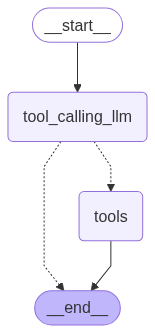

In [167]:
## Entire chatbot with Langgraph

from IPython.display import Image, display
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# build graph
builder=StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm',tools_condition)

builder.add_edge('tools',END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [168]:

messages=graph.invoke({"messages":"What is attention is all you need?"})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is attention is all you need?
================================== Ai Message ==================================
Tool Calls:
  arxiv (pytds6rae)
 Call ID: pytds6rae
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time o


## React Agent Architecture in LangGraph

1. act = The model calls the specific tools
2. observe = Passes the output back to the model
3. reason = Based on the output response of the tool, the model will decide what to do in the next step --> smart agents

In [169]:
os.environ['LANGCHAIN_API_KEY']=os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2']='true'
os.environ['LANGCHAIN_PROJECT']=os.getenv('LANGCHAIN_PROJECT')

In [170]:
## Custom functions --> tools

def multiply(a: int,b: int)->int:
    """
    Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int,b: int)->int:
    """
    Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def subtract(a: int,b: int)->int:
    """
    Subtract a and b.

    Args:
        a: first int
        b: second int
    """
    return a - b

def divide(a: int,b: int)->int:
    """
    Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a // b

In [171]:
## Travily search tool

from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [172]:
tavily.invoke("Provide me the latest news on Independence day today -  15'th Aug, 2025")

[{'title': "Independence Day LIVE: 'Super Six' poll promises in ...",
  'url': 'https://www.thehindu.com/news/national/india-indepdence-day-2025-live-updates-on-august-15-pm-modi-speech/article69935688.ece',
  'content': '## Prime Minister Modi announced the launch of a ₹1 lakh crore scheme for the youth - the PM Viksit Bharat Rozgar Yojana. Under this scheme, those getting their first job in the private sector will get ₹15,000 from the government.\n\nUpdated  - August 15, 2025 11:37 am IST\n\nThe view of historical district collectorate which was illuminated for the 79th Independence Day Celebrations in Vijayawada. Many structures were illuminated and decked for the event. [...] ### 78 Years of Freedom: A collection of stories commemorating the progress of nation\n\nIndependence Day 2025: All you need to know about 78 years of freedom- India’s 79th Independence Day.\n\nPrime Minister Narendra Modi wished the nation on its 79th Independence Day and urged everyone to work even harder to

In [173]:
tools=[tavily,arxiv,wiki,add,multiply,subtract,divide]


In [174]:
llm_with_tools=llm.bind_tools(tools)

In [175]:
from pprint import pprint

from langchain_core.messages import AIMessage,HumanMessage

llm_with_tools.invoke([HumanMessage(content=f"Provide me the latest news on Independence day today -  15'th Aug, 2025. Also after that give me the result of 2 plus 2 multiply by 6 divided by 3. subtract 5 from it")]).tool_calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'Independence Day 15 August 2025 latest news'},
  'id': 'f6wz2zypp',
  'type': 'tool_call'},
 {'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'h8vb5jg22',
  'type': 'tool_call'}]

In [176]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [177]:
## chatbot node functionality

def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}



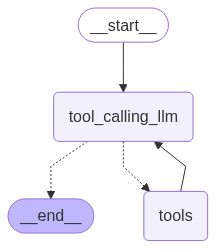

In [178]:
from IPython.display import Image,display
from langgraph.graph import StateGraph, START, END

builder=StateGraph(State)

builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm',tools_condition)
builder.add_edge('tools','tool_calling_llm')


graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [179]:
messages=graph.invoke({"messages":HumanMessage(content=f"Provide me the latest news on Independence day today -  15'th Aug, 2025. Also after that give me the result of 2 plus 2 multiply by 6 divided by 3. subtract 5 from it")}) # type: ignore
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Provide me the latest news on Independence day today -  15'th Aug, 2025. Also after that give me the result of 2 plus 2 multiply by 6 divided by 3. subtract 5 from it
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (2rpnnqdct)
 Call ID: 2rpnnqdct
  Args:
    query: latest news on Independence day 15th Aug 2025
  add (atexb3hx8)
 Call ID: atexb3hx8
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Independence Day 2025 Live Updates: Today's wishes, ...", "url": "https://www.indiatvnews.com/lifestyle/events/independence-day-2025-live-updates-2025-08-14-1003531", "content": "India celebrates its 79th Independence Day today, August 15, 2025, with pride and patriotic fervour. The day marks the nation’s historic freedom from colonial rul

## Agent with memory in LangGraph

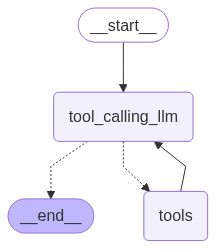

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_with_memory=builder.compile(checkpointer=memory) ## saved in memory

display(Image(graph.get_graph().draw_mermaid_png()))

In [181]:
## specify the thread

config={
    "configurable":{"thread_id":"1"} ## specific to one user
}
messages=graph_with_memory.invoke({"messages":HumanMessage(content=f"Provide me the latest news on Independence day today -  15'th Aug, 2025. Also after that give me the result of 2 plus 2 multiply by 6 divided by 3. subtract 5 from it")},config=config) # type: ignore
for message in messages['messages']:
    message.pretty_print()


================================ Human Message =================================

Provide me the latest news on Independence day today -  15'th Aug, 2025. Also after that give me the result of 2 plus 2 multiply by 6 divided by 3. subtract 5 from it
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (xfabhcsek)
 Call ID: xfabhcsek
  Args:
    query: latest news on Independence day 15th Aug 2025
  add (qzd5h5e9d)
 Call ID: qzd5h5e9d
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "79th Independence Day 2025: Top 10 Key Points You Need to ...", "url": "https://www.jagranjosh.com/general-knowledge/79th-independence-day-2025-top-key-points-from-pm-modis-15-august-speech-1820001579-1", "content": "## India’s 79th Independence Day on 15 August 2025 celebrated freedom, unity, and progress. From the Red Fort, PM Modi honou